# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
%%time
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Wall time: 5.8 s


Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
%%time
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

Wall time: 5 ms


В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
%%time
from torch.optim.lr_scheduler import StepLR

# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size=2, gamma=0.1):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = StepLR(optimizer, step_size, gamma)
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        scheduler.step()
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    # raise Exception("Not implemented")
    
    correct = 0
    total = 0
    
    for x, y in loader:

        prediction = model(x)
        
        indices =  torch.argmax(prediction, dim=1)
        
        correct += (indices == y).sum()
        
        total += y.size(0)
        
    return np.true_divide(correct, total)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

C:\Programs\anaconda\lib\site-packages\torch\optim\lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Average loss: 1.836707, Train accuracy: 0.399669, Val accuracy: 0.539485
Average loss: 1.522475, Train accuracy: 0.562605, Val accuracy: 0.562351
Average loss: 1.496053, Train accuracy: 0.572894, Val accuracy: 0.576957
Wall time: 1min 42s


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
%%time
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.161402, Train accuracy: 0.210013, Val accuracy: 0.257662
Average loss: 2.034466, Train accuracy: 0.264717, Val accuracy: 0.275067
Average loss: 2.006796, Train accuracy: 0.283725, Val accuracy: 0.298614
Average loss: 1.990913, Train accuracy: 0.297051, Val accuracy: 0.300253
Average loss: 1.987801, Train accuracy: 0.299099, Val accuracy: 0.302164
Wall time: 2min 49s


Добавьте слой с Batch Normalization

In [8]:
%%time
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.051332, Train accuracy: 0.313005, Val accuracy: 0.430278
Average loss: 1.825193, Train accuracy: 0.427311, Val accuracy: 0.450140
Average loss: 1.799908, Train accuracy: 0.439545, Val accuracy: 0.449799
Average loss: 1.788122, Train accuracy: 0.446354, Val accuracy: 0.450345
Average loss: 1.785177, Train accuracy: 0.446985, Val accuracy: 0.452665
Wall time: 2min 44s


Добавьте уменьшение скорости обучения по ходу тренировки.

In [9]:
%%time
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.070893, Train accuracy: 0.305447, Val accuracy: 0.419357
Average loss: 1.867471, Train accuracy: 0.425929, Val accuracy: 0.441949
Average loss: 1.843292, Train accuracy: 0.439955, Val accuracy: 0.456283
Average loss: 1.830238, Train accuracy: 0.447940, Val accuracy: 0.457102
Average loss: 1.827020, Train accuracy: 0.449015, Val accuracy: 0.458330
Wall time: 1min 57s


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

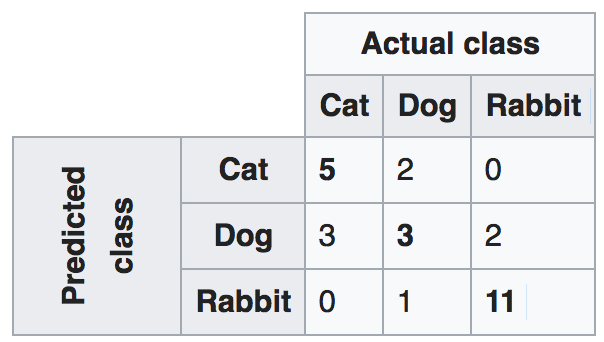

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

In [10]:
%%time
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, sampler=sampler)
    
    predictions, ground_truth = [], []
    for x, y in loader:
        p_predictions = model(x)
        p_indices = torch.argmax(p_predictions, dim=1)
        predictions.append(p_indices)
        ground_truth.append(y)
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

Wall time: 10.2 s


Wall time: 5.52 s


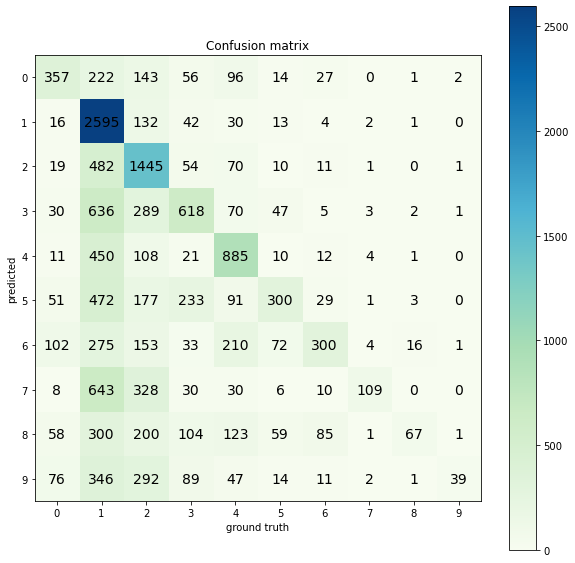

In [11]:
%%time
from sklearn.metrics import confusion_matrix

def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
#     confusion_matrix = np.zeros((10,10), np.int)
    _confusion_matrix = confusion_matrix(ground_truth, predictions)
    # TODO: Implement filling the prediction matrix
    # np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    
    return _confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [20]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    indexes = val_indices[(predictions == predicted_class) & (ground_truth == gt_class)]
    visualize_images(indexes, data, "Classes that are predicted wrong")

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

<Figure size 720x108 with 0 Axes>

<Figure size 720x108 with 0 Axes>

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [21]:
# Experiment here!
import itertools

In [25]:
lr_params = [1e-3, 1e-6]
n_neurons_params = [100, 200]
weight_decay_params = [1e-2, 1e-4]
optimizer_params = [optim.SGD, optim.Adam, optim.RMSprop]
n_epochs = 25

In [26]:
best_classifier = None
best_optimizer = None
best_val_accuracy = None

In [34]:
%%time
for lr, n_neurons, weight_decay, nn_optimizer in itertools.product(
                                                    lr_params,
                                                    n_neurons_params,
                                                    weight_decay_params,
                                                    optimizer_params
                                                ):
    
    print(f'learning rate={lr}, number of neurons={n_neurons}, weight_decay={weight_decay}, optimizer={nn_optimizer.__name__}')
    
    nn_models = [
        nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, n_neurons),
                nn.ReLU(inplace=True),
                nn.Linear(n_neurons, n_neurons),
                nn.ReLU(inplace=True),
                nn.Linear(n_neurons, 10), 
           ),
        nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, n_neurons),
                nn.BatchNorm1d(n_neurons),
                nn.ReLU(inplace=True),
                nn.Linear(n_neurons, n_neurons),
                nn.BatchNorm1d(n_neurons),
                nn.ReLU(inplace=True),
                nn.Linear(n_neurons, 10), 
             )
    ]
    
    for nn_model in nn_models:
        optimizer = nn_optimizer(nn_model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, n_epochs)
        accuracy = val_history[-1]
        print("Val history: ")
        print(val_history)
        
        if not best_val_accuracy or accuracy > best_val_accuracy:
            best_classifier = nn_model
            best_optimizer = optimizer
            best_val_accuracy = accuracy

learning rate=0.001, number of neurons=100, weight_decay=0.01, optimizer=SGD
Average loss: 2.267290, Train accuracy: 0.163618, Val accuracy: 0.198348
Average loss: 2.238345, Train accuracy: 0.196226, Val accuracy: 0.199236
Average loss: 2.234885, Train accuracy: 0.197113, Val accuracy: 0.201147
Average loss: 2.232999, Train accuracy: 0.197778, Val accuracy: 0.200874
Average loss: 2.232662, Train accuracy: 0.197983, Val accuracy: 0.200737
Average loss: 2.232497, Train accuracy: 0.198068, Val accuracy: 0.200669
Average loss: 2.232445, Train accuracy: 0.198086, Val accuracy: 0.200601
Average loss: 2.232440, Train accuracy: 0.198068, Val accuracy: 0.200601
Average loss: 2.232416, Train accuracy: 0.198068, Val accuracy: 0.200601
Average loss: 2.232409, Train accuracy: 0.198068, Val accuracy: 0.200601
Average loss: 2.232433, Train accuracy: 0.198068, Val accuracy: 0.200601
Average loss: 2.232438, Train accuracy: 0.198068, Val accuracy: 0.200601
Average loss: 2.232438, Train accuracy: 0.19806

Average loss: 1.483990, Train accuracy: 0.521585, Val accuracy: 0.618524
Average loss: 1.067586, Train accuracy: 0.682865, Val accuracy: 0.714422
Average loss: 0.977393, Train accuracy: 0.710917, Val accuracy: 0.730326
Average loss: 0.902361, Train accuracy: 0.737638, Val accuracy: 0.752713
Average loss: 0.879511, Train accuracy: 0.746084, Val accuracy: 0.757218
Average loss: 0.869182, Train accuracy: 0.750537, Val accuracy: 0.759470
Average loss: 0.861353, Train accuracy: 0.752466, Val accuracy: 0.759334
Average loss: 0.863154, Train accuracy: 0.751834, Val accuracy: 0.758924
Average loss: 0.863663, Train accuracy: 0.751442, Val accuracy: 0.761859
Average loss: 0.861355, Train accuracy: 0.750384, Val accuracy: 0.757081
Average loss: 0.862012, Train accuracy: 0.752005, Val accuracy: 0.762201
Average loss: 0.864071, Train accuracy: 0.748524, Val accuracy: 0.760699
Average loss: 0.864287, Train accuracy: 0.749804, Val accuracy: 0.756945
Average loss: 0.864108, Train accuracy: 0.749923, V

Average loss: 2.269173, Train accuracy: 0.160547, Val accuracy: 0.201761
Average loss: 2.240366, Train accuracy: 0.199007, Val accuracy: 0.204901
Average loss: 2.236927, Train accuracy: 0.201345, Val accuracy: 0.206948
Average loss: 2.234988, Train accuracy: 0.202778, Val accuracy: 0.206880
Average loss: 2.234649, Train accuracy: 0.202863, Val accuracy: 0.207426
Average loss: 2.234462, Train accuracy: 0.202949, Val accuracy: 0.207426
Average loss: 2.234406, Train accuracy: 0.202983, Val accuracy: 0.207426
Average loss: 2.234379, Train accuracy: 0.203000, Val accuracy: 0.207426
Average loss: 2.234380, Train accuracy: 0.203000, Val accuracy: 0.207426
Average loss: 2.234403, Train accuracy: 0.203000, Val accuracy: 0.207426
Average loss: 2.234401, Train accuracy: 0.203000, Val accuracy: 0.207426
Average loss: 2.234375, Train accuracy: 0.203000, Val accuracy: 0.207426
Average loss: 2.234399, Train accuracy: 0.203000, Val accuracy: 0.207426
Average loss: 2.234415, Train accuracy: 0.203000, V

Average loss: 1.338400, Train accuracy: 0.566256, Val accuracy: 0.702819
Average loss: 0.880203, Train accuracy: 0.731000, Val accuracy: 0.752850
Average loss: 0.819083, Train accuracy: 0.749104, Val accuracy: 0.769436
Average loss: 0.775173, Train accuracy: 0.763403, Val accuracy: 0.770459
Average loss: 0.769274, Train accuracy: 0.764461, Val accuracy: 0.772575
Average loss: 0.766473, Train accuracy: 0.765519, Val accuracy: 0.770323
Average loss: 0.761050, Train accuracy: 0.767191, Val accuracy: 0.772029
Average loss: 0.764992, Train accuracy: 0.766440, Val accuracy: 0.772985
Average loss: 0.764327, Train accuracy: 0.766764, Val accuracy: 0.773190
Average loss: 0.762787, Train accuracy: 0.765860, Val accuracy: 0.772439
Average loss: 0.764997, Train accuracy: 0.767089, Val accuracy: 0.772575
Average loss: 0.763753, Train accuracy: 0.766116, Val accuracy: 0.773463
Average loss: 0.760443, Train accuracy: 0.768061, Val accuracy: 0.772575
Average loss: 0.763005, Train accuracy: 0.768334, V

Average loss: 2.261620, Train accuracy: 0.185851, Val accuracy: 0.206812
Average loss: 2.235800, Train accuracy: 0.201805, Val accuracy: 0.206812
Average loss: 2.232941, Train accuracy: 0.201993, Val accuracy: 0.206539
Average loss: 2.231352, Train accuracy: 0.201754, Val accuracy: 0.206744
Average loss: 2.231095, Train accuracy: 0.201771, Val accuracy: 0.206675
Average loss: 2.230974, Train accuracy: 0.201754, Val accuracy: 0.206675
Average loss: 2.230945, Train accuracy: 0.201771, Val accuracy: 0.206675
Average loss: 2.230906, Train accuracy: 0.201754, Val accuracy: 0.206675
Average loss: 2.230894, Train accuracy: 0.201771, Val accuracy: 0.206675
Average loss: 2.230926, Train accuracy: 0.201771, Val accuracy: 0.206675
Average loss: 2.230902, Train accuracy: 0.201771, Val accuracy: 0.206675
Average loss: 2.230927, Train accuracy: 0.201771, Val accuracy: 0.206675
Average loss: 2.230913, Train accuracy: 0.201771, Val accuracy: 0.206675
Average loss: 2.230897, Train accuracy: 0.201771, V

Average loss: 1.452858, Train accuracy: 0.532795, Val accuracy: 0.630537
Average loss: 1.028859, Train accuracy: 0.697130, Val accuracy: 0.721794
Average loss: 0.919673, Train accuracy: 0.727383, Val accuracy: 0.752645
Average loss: 0.827746, Train accuracy: 0.758591, Val accuracy: 0.771483
Average loss: 0.809772, Train accuracy: 0.765041, Val accuracy: 0.777558
Average loss: 0.792438, Train accuracy: 0.770945, Val accuracy: 0.778309
Average loss: 0.787340, Train accuracy: 0.772737, Val accuracy: 0.778855
Average loss: 0.788162, Train accuracy: 0.770979, Val accuracy: 0.779674
Average loss: 0.788610, Train accuracy: 0.772208, Val accuracy: 0.780629
Average loss: 0.786904, Train accuracy: 0.773692, Val accuracy: 0.780629
Average loss: 0.789009, Train accuracy: 0.771508, Val accuracy: 0.779059
Average loss: 0.785684, Train accuracy: 0.772890, Val accuracy: 0.777558
Average loss: 0.785157, Train accuracy: 0.772464, Val accuracy: 0.779332
Average loss: 0.785192, Train accuracy: 0.773812, V

Average loss: 2.257658, Train accuracy: 0.172269, Val accuracy: 0.204286
Average loss: 2.229105, Train accuracy: 0.198154, Val accuracy: 0.203604
Average loss: 2.225819, Train accuracy: 0.198171, Val accuracy: 0.203126
Average loss: 2.223907, Train accuracy: 0.197727, Val accuracy: 0.203126
Average loss: 2.223565, Train accuracy: 0.197761, Val accuracy: 0.203126
Average loss: 2.223395, Train accuracy: 0.197744, Val accuracy: 0.203126
Average loss: 2.223361, Train accuracy: 0.197744, Val accuracy: 0.203126
Average loss: 2.223330, Train accuracy: 0.197744, Val accuracy: 0.203126
Average loss: 2.223332, Train accuracy: 0.197744, Val accuracy: 0.203126
Average loss: 2.223334, Train accuracy: 0.197744, Val accuracy: 0.203126
Average loss: 2.223368, Train accuracy: 0.197744, Val accuracy: 0.203126
Average loss: 2.223330, Train accuracy: 0.197744, Val accuracy: 0.203126
Average loss: 2.223348, Train accuracy: 0.197744, Val accuracy: 0.203126
Average loss: 2.223344, Train accuracy: 0.197744, V

Average loss: 1.284177, Train accuracy: 0.585077, Val accuracy: 0.709986
Average loss: 0.811395, Train accuracy: 0.749480, Val accuracy: 0.770459
Average loss: 0.747992, Train accuracy: 0.770382, Val accuracy: 0.783633
Average loss: 0.702269, Train accuracy: 0.783913, Val accuracy: 0.788820
Average loss: 0.691882, Train accuracy: 0.787974, Val accuracy: 0.788069
Average loss: 0.687378, Train accuracy: 0.789527, Val accuracy: 0.789093
Average loss: 0.685750, Train accuracy: 0.790226, Val accuracy: 0.788342
Average loss: 0.685006, Train accuracy: 0.790090, Val accuracy: 0.790117
Average loss: 0.683839, Train accuracy: 0.788981, Val accuracy: 0.790458
Average loss: 0.685376, Train accuracy: 0.789851, Val accuracy: 0.791141
Average loss: 0.687173, Train accuracy: 0.787974, Val accuracy: 0.790799
Average loss: 0.687732, Train accuracy: 0.788708, Val accuracy: 0.790663
Average loss: 0.686792, Train accuracy: 0.788691, Val accuracy: 0.789980
Average loss: 0.684288, Train accuracy: 0.791523, V

Average loss: 2.306989, Train accuracy: 0.096082, Val accuracy: 0.094465
Average loss: 2.306891, Train accuracy: 0.096219, Val accuracy: 0.094465
Average loss: 2.306880, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306874, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306875, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306874, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306869, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306873, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306872, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306876, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306866, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306870, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306879, Train accuracy: 0.096253, Val accuracy: 0.094465
Average loss: 2.306885, Train accuracy: 0.096253, V

Average loss: 2.391407, Train accuracy: 0.092857, Val accuracy: 0.100403
Average loss: 2.350443, Train accuracy: 0.100894, Val accuracy: 0.103269
Average loss: 2.344665, Train accuracy: 0.103965, Val accuracy: 0.103474
Average loss: 2.340297, Train accuracy: 0.103931, Val accuracy: 0.104293
Average loss: 2.340773, Train accuracy: 0.104102, Val accuracy: 0.104157
Average loss: 2.340115, Train accuracy: 0.104887, Val accuracy: 0.105590
Average loss: 2.339528, Train accuracy: 0.105689, Val accuracy: 0.103815
Average loss: 2.339416, Train accuracy: 0.105484, Val accuracy: 0.104839
Average loss: 2.339759, Train accuracy: 0.105313, Val accuracy: 0.104020
Average loss: 2.340018, Train accuracy: 0.104665, Val accuracy: 0.104430
Average loss: 2.339683, Train accuracy: 0.105621, Val accuracy: 0.104566
Average loss: 2.339938, Train accuracy: 0.103744, Val accuracy: 0.105112
Average loss: 2.339768, Train accuracy: 0.105399, Val accuracy: 0.103065
Average loss: 2.339566, Train accuracy: 0.104802, V

Average loss: 2.303806, Train accuracy: 0.082824, Val accuracy: 0.084226
Average loss: 2.303727, Train accuracy: 0.082995, Val accuracy: 0.084226
Average loss: 2.303721, Train accuracy: 0.083012, Val accuracy: 0.084158
Average loss: 2.303718, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303717, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303719, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303716, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303715, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303715, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303707, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303717, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303724, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303718, Train accuracy: 0.083029, Val accuracy: 0.084158
Average loss: 2.303708, Train accuracy: 0.083029, V

Average loss: 2.317595, Train accuracy: 0.131045, Val accuracy: 0.144632
Average loss: 2.278059, Train accuracy: 0.147289, Val accuracy: 0.151184
Average loss: 2.272083, Train accuracy: 0.151657, Val accuracy: 0.152276
Average loss: 2.269224, Train accuracy: 0.154148, Val accuracy: 0.152891
Average loss: 2.268755, Train accuracy: 0.154916, Val accuracy: 0.155006
Average loss: 2.268656, Train accuracy: 0.153619, Val accuracy: 0.158556
Average loss: 2.268268, Train accuracy: 0.153005, Val accuracy: 0.154597
Average loss: 2.268616, Train accuracy: 0.154387, Val accuracy: 0.153300
Average loss: 2.268193, Train accuracy: 0.153790, Val accuracy: 0.154392
Average loss: 2.268677, Train accuracy: 0.153466, Val accuracy: 0.154802
Average loss: 2.268572, Train accuracy: 0.153483, Val accuracy: 0.152891
Average loss: 2.268546, Train accuracy: 0.153193, Val accuracy: 0.151594
Average loss: 2.268419, Train accuracy: 0.153994, Val accuracy: 0.151457
Average loss: 2.268541, Train accuracy: 0.153739, V

Average loss: 2.322844, Train accuracy: 0.078285, Val accuracy: 0.076104
Average loss: 2.322727, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322713, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322711, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322711, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322693, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322711, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322709, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322718, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322713, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322715, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322705, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322706, Train accuracy: 0.078337, Val accuracy: 0.076104
Average loss: 2.322711, Train accuracy: 0.078337, V

Average loss: 2.283644, Train accuracy: 0.158124, Val accuracy: 0.202034
Average loss: 2.227074, Train accuracy: 0.201754, Val accuracy: 0.208313
Average loss: 2.218221, Train accuracy: 0.208050, Val accuracy: 0.217664
Average loss: 2.212797, Train accuracy: 0.211736, Val accuracy: 0.217869
Average loss: 2.211601, Train accuracy: 0.213869, Val accuracy: 0.217391
Average loss: 2.212037, Train accuracy: 0.212930, Val accuracy: 0.218688
Average loss: 2.211681, Train accuracy: 0.214927, Val accuracy: 0.217596
Average loss: 2.211699, Train accuracy: 0.214278, Val accuracy: 0.217596
Average loss: 2.211611, Train accuracy: 0.214261, Val accuracy: 0.216709
Average loss: 2.211522, Train accuracy: 0.214961, Val accuracy: 0.218279
Average loss: 2.211214, Train accuracy: 0.215405, Val accuracy: 0.218210
Average loss: 2.211717, Train accuracy: 0.213340, Val accuracy: 0.219029
Average loss: 2.211732, Train accuracy: 0.212589, Val accuracy: 0.216709
Average loss: 2.211744, Train accuracy: 0.212794, V

Average loss: 2.334382, Train accuracy: 0.072740, Val accuracy: 0.073442
Average loss: 2.334214, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334208, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334197, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334201, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334188, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334203, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334195, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334196, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334191, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334188, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334196, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334201, Train accuracy: 0.072757, Val accuracy: 0.073442
Average loss: 2.334196, Train accuracy: 0.072757, V

Average loss: 2.321979, Train accuracy: 0.111234, Val accuracy: 0.144973
Average loss: 2.269911, Train accuracy: 0.154967, Val accuracy: 0.152413
Average loss: 2.262320, Train accuracy: 0.162594, Val accuracy: 0.163607
Average loss: 2.257394, Train accuracy: 0.166894, Val accuracy: 0.165108
Average loss: 2.256907, Train accuracy: 0.167304, Val accuracy: 0.162583
Average loss: 2.256110, Train accuracy: 0.168856, Val accuracy: 0.165176
Average loss: 2.256312, Train accuracy: 0.168600, Val accuracy: 0.165449
Average loss: 2.256038, Train accuracy: 0.169454, Val accuracy: 0.166746
Average loss: 2.256363, Train accuracy: 0.168362, Val accuracy: 0.166951
Average loss: 2.256249, Train accuracy: 0.167816, Val accuracy: 0.164153
Average loss: 2.256470, Train accuracy: 0.169368, Val accuracy: 0.159511
Average loss: 2.255747, Train accuracy: 0.169437, Val accuracy: 0.166815
Average loss: 2.256330, Train accuracy: 0.168362, Val accuracy: 0.166337
Average loss: 2.255875, Train accuracy: 0.169164, V

In [40]:
print(best_classifier)
print(best_optimizer)
print(best_val_accuracy)

n_neurons = 200
nn_model = nn.Sequential(
                Flattener(),
                nn.Linear(3*32*32, n_neurons),
                nn.ReLU(inplace=True),
                nn.Linear(n_neurons, n_neurons),
                nn.ReLU(inplace=True),
                nn.Linear(n_neurons, 10), 
           )

Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=200, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=200, out_features=200, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=200, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 1.0000000000000009e-15
    weight_decay: 0.0001
)
tensor(0.7945, dtype=torch.float64)


In [42]:
%%time
optimizer = nn_optimizer(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 8)
accuracy = val_history[-1]

print("accuracy: " + str(accuracy))

Average loss: 1.325541, Train accuracy: 0.590196, Val accuracy: 0.693605
Average loss: 0.752423, Train accuracy: 0.773061, Val accuracy: 0.770323
Average loss: 0.687730, Train accuracy: 0.793690, Val accuracy: 0.779742
Average loss: 0.641641, Train accuracy: 0.808723, Val accuracy: 0.785475
Average loss: 0.634357, Train accuracy: 0.811538, Val accuracy: 0.786021
Average loss: 0.628772, Train accuracy: 0.813398, Val accuracy: 0.786977
Average loss: 0.627803, Train accuracy: 0.813415, Val accuracy: 0.787864
Average loss: 0.627254, Train accuracy: 0.813671, Val accuracy: 0.787933
accuracy: tensor(0.7879, dtype=torch.float64)
Wall time: 3min 42s


In [43]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7619
